# **Predict Credit Card Fraud**

Credit card fraud is one of the leading causes of identify theft around the world. In 2018 alone, over $24 billion were stolen through fraudulent credit card transactions. Financial institutions employ a wide variety of different techniques to prevent fraud, one of the most common being Logistic Regression.

In this project, I will work on the dataset (based on a synthetic financial dataset), that represents a typical set of credit card transactions. transactions.csv is the original dataset which contains one thousand transactions. My goal is to use Logistic Regression and create a predictive model to determine if a transaction is fraudulent or not.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


In [4]:
# prompt: upload file

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving transactions.csv to transactions.csv
User uploaded file "transactions.csv" with length 85135 bytes


In [5]:
transactions = pd.read_csv('transactions.csv')

# **Explorative Data Analysis**

In [6]:
print(transactions.head())

   step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   206  CASH_OUT    62927.08   C473782114           0.00            0.00   
1   380   PAYMENT    32851.57  C1915112886           0.00            0.00   
2   570  CASH_OUT  1131750.38  C1396198422     1131750.38            0.00   
3   184  CASH_OUT    60519.74   C982551468       60519.74            0.00   
4   162   CASH_IN    46716.01  C1759889425     7668050.60      7714766.61   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isPayment  \
0  C2096898696       649420.67       712347.75        0          0   
1   M916879292            0.00            0.00        0          1   
2  C1612235515       313070.53      1444820.92        1          0   
3  C1378644910        54295.32       182654.50        1          0   
4  C2059152908      2125468.75      2078752.75        0          0   

   isMovement  accountDiff  
0           1    649420.67  
1           0         0.00  
2           1    818679.85  


Here are some interpretations of columns:

isPayment: assigns a 1 when type is “PAYMENT” or “DEBIT”, and a 0 otherwise

isMovement: captures if money moved out of the origin account. This column will have a value of 1 when type is either “CASH_OUT” or “TRANSFER”, and a 0 otherwise.

accountDiff: the absolute difference of the oldbalanceOrg and oldbalanceDest columns. With financial fraud, another key factor to investigate would be the difference in value between the origin and destination account. Our theory, in this case, being that destination accounts with a significantly different value could be suspect of fraud.


In [7]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            1000 non-null   int64  
 1   type            1000 non-null   object 
 2   amount          1000 non-null   float64
 3   nameOrig        1000 non-null   object 
 4   oldbalanceOrg   1000 non-null   float64
 5   newbalanceOrig  1000 non-null   float64
 6   nameDest        1000 non-null   object 
 7   oldbalanceDest  1000 non-null   float64
 8   newbalanceDest  1000 non-null   float64
 9   isFraud         1000 non-null   int64  
 10  isPayment       1000 non-null   int64  
 11  isMovement      1000 non-null   int64  
 12  accountDiff     1000 non-null   float64
dtypes: float64(6), int64(4), object(3)
memory usage: 101.7+ KB


It appears that there is no missing data. We can further explore descriptive analysis

In [9]:
print(transactions.describe())

              step        amount  oldbalanceOrg  newbalanceOrig  \
count  1000.000000  1.000000e+03   1.000000e+03    1.000000e+03   
mean    280.664000  5.373080e+05   1.049284e+06    6.376146e+05   
std     167.174593  1.423692e+06   3.226500e+06    2.717351e+06   
min       1.000000  0.000000e+00   0.000000e+00    0.000000e+00   
25%     164.000000  2.933705e+04   1.287500e+02    0.000000e+00   
50%     261.000000  1.265305e+05   4.371400e+04    0.000000e+00   
75%     373.250000  3.010378e+05   4.080914e+05    3.795663e+04   
max     741.000000  1.000000e+07   5.039905e+07    4.039905e+07   

       oldbalanceDest  newbalanceDest      isFraud    isPayment   isMovement  \
count    1.000000e+03    1.000000e+03  1000.000000  1000.000000  1000.000000   
mean     1.028848e+06    1.302326e+06     0.282000     0.220000     0.605000   
std      2.678541e+06    3.038042e+06     0.450198     0.414454     0.489095   
min      0.000000e+00    0.000000e+00     0.000000     0.000000     0.000000

In [10]:
transactions.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isPayment',
       'isMovement', 'accountDiff'],
      dtype='object')

Let's see how many fraudulant transactions are recorded

In [11]:
print('total fraudulant transactions: ', np.sum(transactions['isFraud']))

total fraudulant transactions:  282


<ipython-input-16-321595198ab8>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='amount', data=transactions, palette = 'Set2')


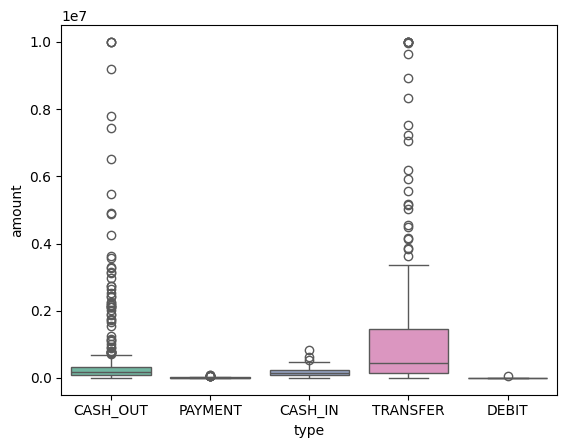

In [16]:
sns.boxplot(x='type', y='amount', data=transactions, palette = 'Set2')
plt.show();

Comparing Transaction Types:

'TRANSFER' and 'CASH_OUT' transactions tend to have higher median amounts compared to other types like 'PAYMENT' and 'DEBIT'.

'TRANSFER' transactions exhibit a wider IQR, indicating greater variability in transaction amounts compared to other types.

Several outliers are observed for 'TRANSFER' and 'CASH_OUT' transactions, suggesting potential fraudulent or unusual activity.

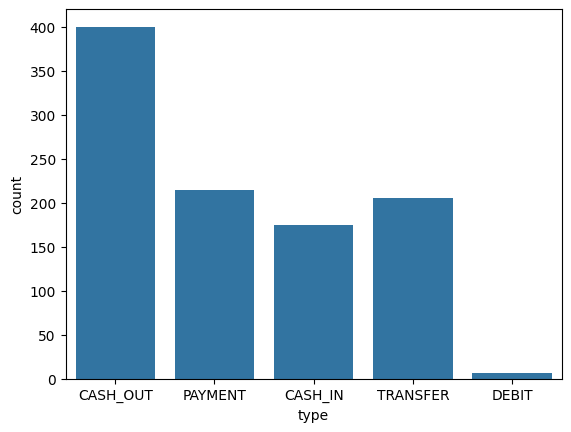

In [19]:
# prompt: barplot on type

sns.countplot(x='type', data=transactions)
plt.show()

We can see that most transactions are cash-out type. By combining the result from both bar plot and boxplot, we can see that while 'CASH_OUT' is the most frequent, 'TRANSFER' and 'CASH_OUT' transactions tend to involve larger amounts and have a higher potential for fraud due to the presence of outliers.

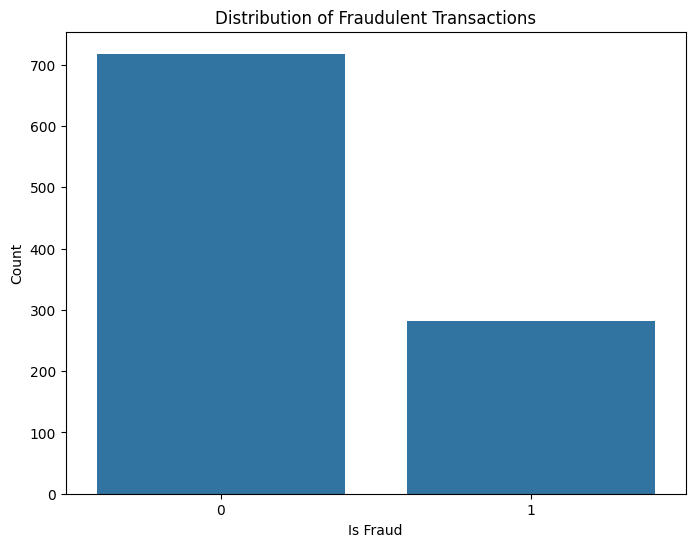

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='isFraud', data=transactions)
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Count')
plt.show()

# **Select and Split data**

Before we can start training our model, we need to define our features and label columns. Our label column in this dataset is the isFraud field.
And features will be:

amount

isPayment

isMovement

accountDiff


In [20]:
features = transactions[['amount', 'isPayment', 'isMovement', 'accountDiff']]
label = transactions['isFraud']

In [23]:
# prompt: split the dataset

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

In [24]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Create a logistic regression model
model = LogisticRegression()

# Train the model on the scaled training data
model.fit(X_train_scaled, y_train)

# Evaluate the model on the training set using the .score() method

train_accuracy = model.score(X_train_scaled, y_train)
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.8385714285714285


It appears that the model classified transactions almost 84% accurately.

In [26]:
# Make predictions on the scaled test set
y_pred = model.predict(X_test_scaled)

# Evaluate the model on the test set
test_accuracy = model.score(X_test_scaled, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.85


Interpretation:

Scoring the model on the test data will process the test data through the trained model and will predict which transactions are fraudulent. The score returned is the percentage of correct classifications, or the accuracy, and will be an indicator for the sucess of the model. Our model shows 85% of accuracy, which seems good. Now let's see which feature was the most important predictor

In [30]:
# Get the coefficients and the corresponding feature names
coefficients = model.coef_[0]
feature_names = features.columns

coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    })

print(coef_df)

       Feature  Coefficient
0       amount     2.421104
1    isPayment    -0.610504
2   isMovement     2.101479
3  accountDiff    -0.987915


amount : For each unit increase in the amount feature, the log odds of the predicted outcome increase by 2.42. This suggests that higher amount values are associated with a higher probability of the fraud

isPayment: Being a "payment" (if transaction is a PAYMENT or DEBIT) decreases the log odds of the positive outcome by 0.61. This means that if a transaction is labeled as a payment, the probability of the fraud is lower.

isMovement: If the transaction involves a CASH_OUT or TRANSFER, the log odds of the fraud increase by 2.10. This suggests that cash out or transfer is positively associated with the fraud.

accountDiff: A higher difference between oldbalanceOrg and oldbalanceDest reduces the likelihood of the fraud by 0.99 on the log odds scale.

The feature **amount** has the largest absolute coefficient (2.421104), meaning it is the strongest predictor in this model.

In contrast, The feature **isPayment** has the smallest absolute coefficient (0.610504), meaning it is the weakest predictor in this model.

Now let’s check our model to process more transactions. There are three numpy arrays for the experiment

In [59]:
# Sample data for prediction
new_transactions = np.array([[1000, 1, 0, 100],  # Transaction 1
                            [500299, 1, 1, 5000],   # Transaction 2
                            [6000000, 1, 0, 2000]]) # Transaction 3


# Scale the new transaction data using the same scaler as before
new_transactions_scaled = scaler.transform(new_transactions)


# Make predictions on the scaled new transactions
new_predictions = model.predict(new_transactions_scaled)

print("Predictions for new transactions:", new_predictions)

Predictions for new transactions: [0 0 1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Let's check the probability of the outcome

In [60]:
print("Probabilities for new transactions:")
print(model.predict_proba(new_transactions_scaled)[:,1])

Probabilities for new transactions:
[0.00164831 0.21688481 0.97456785]


We can see that the first transaction has the least chance of being fraud.

The 2nd transaction has 21% of being fraud while the last transaction is 97% likely to be fraud

# **Conclusion**

In this project, I have built a Logistic Regression model to predict credit card fraud using a synthetic financial dataset. The model achieved a test accuracy of approximately 85%, demonstrating its effectiveness in identifying potentially fraudulent transactions. Feature analysis revealed that 'amount', 'isMovement', and 'accountDiff' were the most influential predictors of fraud. Notably, higher transaction amounts and those involving cash-outs or transfers were associated with a greater likelihood of fraud.

Wrap-up of Findings:

Data Exploration: Exploratory data analysis (EDA) revealed that 'TRANSFER' and 'CASH_OUT' transactions typically involve larger amounts and exhibit a higher potential for fraud compared to other transaction types. The dataset was predominantly composed of 'CASH_OUT' transactions.

Model Building: A Logistic Regression model was trained on scaled features, including 'amount', 'isPayment', 'isMovement', and 'accountDiff'. The model achieved a respectable training accuracy of 84%.

Model Evaluation: Evaluation on the test set yielded an accuracy of approximately 85%, demonstrating the model's generalization ability.
Feature Importance: Feature analysis highlighted 'amount' as the strongest predictor of fraud, followed by 'isMovement' and 'accountDiff'. 'isPayment' had the least impact on fraud prediction.

Prediction on New Transactions: The model was used to predict the likelihood of fraud in three sample transactions, providing insights into its practical application.

Limitations: The project utilized a synthetic dataset, which may not fully represent real-world fraud patterns. Further validation with real-world data is crucial. Additional features and alternative algorithms could potentially enhance model performance.